# Predicting Rent Prices for houses/apartments in the Brazilian Real Estate Market
## By: Karim Zakir
In this notebook, I will analyze and build a model from start to finish for the [Brazilian Houses To Rent](https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent) dataset found on Kaggle. I will visualize the data, preprocess it for machine learning, create/optimize a machine learning model, and finally analyze the model's accuracy. Let's start by importing the necessary libraries and taking a glance at the dataset.

In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [6]:
houses = pd.read_csv("datasets/houses_to_rent_v2.csv")
houses.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [7]:
houses.shape

(10692, 13)

As you can see, there are 10692 observations and 13 columns in the dataset. Most of the columns are (or seem to be) numerical, while some like 'city', 'animal', and 'furniture' are categorical. We will make sure to encode these columns later.

### Data Analysis and Visualization

The first main section of this notebook will focus Data Analysis and Visualization. In this section, we will get to know the data, analyze and visualize it, and select the target variable for our machine learning model.

We will begin by looking at the data distribution for each of the numerical columns and analyzing them. 

In [8]:
num_cols = houses.select_dtypes(include=np.number).columns.tolist()
num_cols

['area',
 'rooms',
 'bathroom',
 'parking spaces',
 'hoa (R$)',
 'rent amount (R$)',
 'property tax (R$)',
 'fire insurance (R$)',
 'total (R$)']

Although most of the numerical columns are present in the above list, it is missing the floor column, which, logically, should be numerical. Let's check the unique values for this column.

In [9]:
houses["floor"].unique()

array(['7', '20', '6', '2', '1', '-', '4', '3', '10', '11', '24', '9',
       '8', '17', '18', '5', '13', '15', '16', '14', '26', '12', '21',
       '19', '22', '27', '23', '35', '25', '46', '28', '29', '301', '51',
       '32'], dtype=object)

As you can see, this column's data type is object, because it contains the string value '-'. It is possible that this value can represent missing data; however, my initial instict was that this value represents houses or apartments on the ground floor. As [confirmed by the author](https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent/discussion/161708), these values represent houses, so this allows us to have a clear distinction between apartments/houses in our dataset. As such, we will convert the floor column into a numerical column by replacing the '-' with 0.

In [10]:
houses["floor"] = houses["floor"].replace({"-": "0"}).astype(int)

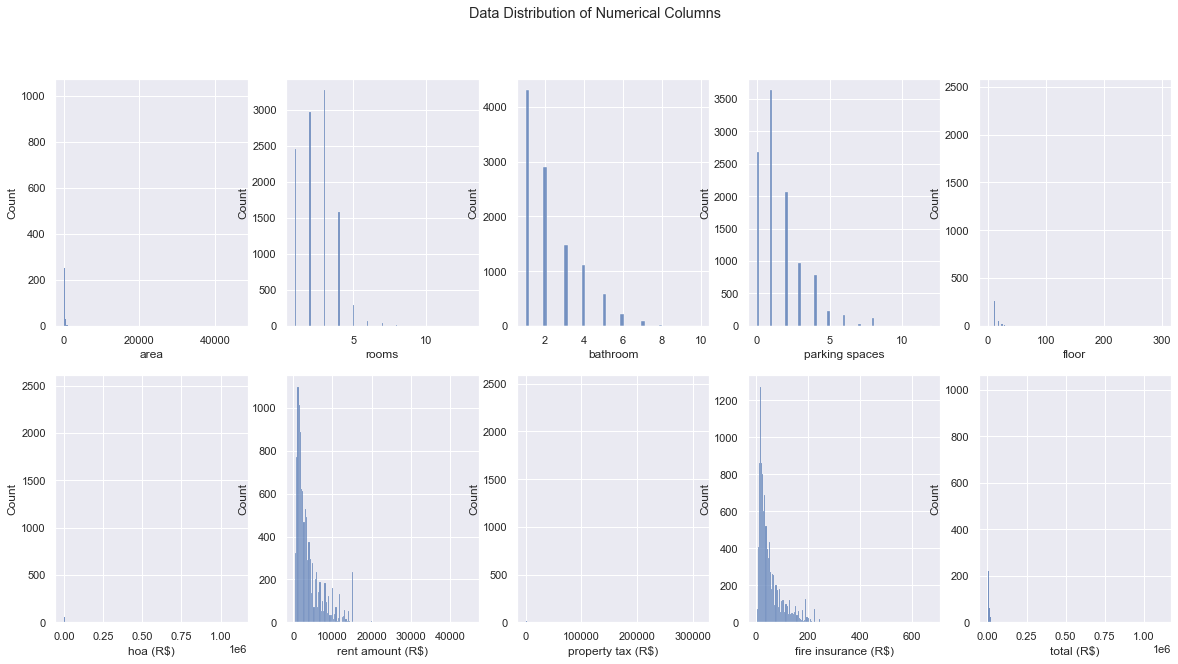

In [11]:
num_cols = houses.select_dtypes(include=np.number).columns.tolist()
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle("Data Distribution of Numerical Columns")
for index, col in enumerate(num_cols):
    if index < 5:  
        sns.histplot(ax=axs[0][index], data=houses, x=col)
    else:
        sns.histplot(ax=axs[1][index-5], data=houses, x=col)
plt.show()

Based on the above plots, we can see that the distributions for the numeric columns are heavily skewed to the right, suggesting that there are more low to middle-class houses/apartments than high-class apartments/houses in the dataset. 

Some of the plots, such as the property tax or area plots, are not displayed as well as we would have hoped. This is because of the extreme values that occur at the end of the distributions. We will take a closer look at these observations in the later section. At the moment, we will set axis limits to the plots in order to take a better look at the majority of values in those columns.

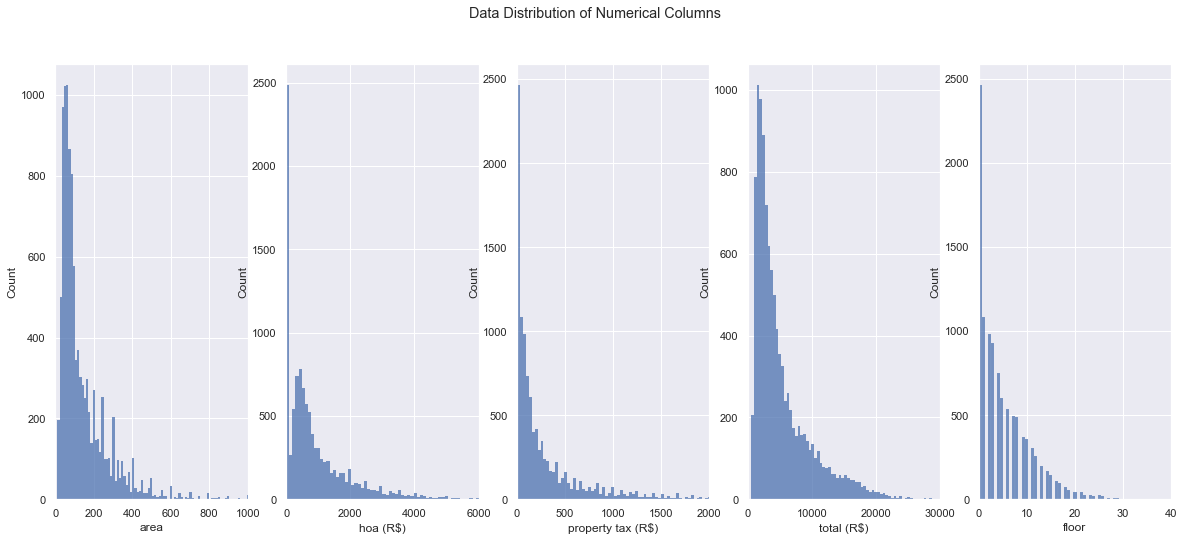

In [12]:
fig, axs = plt.subplots(1, 5, figsize=(20, 8))
fig.suptitle("Data Distribution of Numerical Columns")
area_plot = sns.histplot(ax=axs[0], data=houses, x="area")
area_plot.set(xlim=(0, 1000))
hoa_plot = sns.histplot(ax=axs[1], data=houses, x="hoa (R$)")
hoa_plot.set(xlim=(0, 6000))
pt_plot = sns.histplot(ax=axs[2], data=houses, x="property tax (R$)")
pt_plot.set(xlim=(0, 2000))
total_plot = sns.histplot(ax=axs[3], data=houses, x="total (R$)")
total_plot.set(xlim=(0, 30000))
floor_plot = sns.histplot(ax=axs[4], data=houses, x="floor")
floor_plot.set(xlim=(0, 40))
plt.show()

Similarly to previous data distributions, the data distributions above are heavily skewed to the right, reinforcing the idea that this dataset is mostly made up of low to middle-class housing.

These data distributions can help us pick the target variable for our model. The first call would be to have the 'total' column be the target variable, since, in addition to reflecting the rent price, it also includes taxes/insurances that the tenant would have to pay; however the model would become unrealiable in my opinion, because of the inconsistencies present in the 'hoa' and the 'property tax' columns. For instance, the 'hoa' column represents the home owners association tax. As you can see within the plot above, a lot of the observations have home owners association tax equal to 0. It is not clear whether this indicates missing data or an exemption from the tax. This is also the case for the 'property tax' column. Additionally, as we saw previously, there are outliers in the hoa and the property tax columns, which cause the total column to also have outliers that we will have to deal with later. As such, it is best to use the rent amount column as the target variable, since it does not depend on inconsistent columns in the dataset or does not require background knowledge about the Brazilian taxation system. Additionally, another benefit of using the 'rent amount' column instead of the 'total' column is that the model will not be affected by the changes in the taxation system within Brazil, making our model more future-proof. 

Let's save our potential X and y dataframes and look at the categorical variables in the dataset. We are completely excluding columns like 'fire insurance', 'property tax', and 'total' from our X dataframe, because data from these columns will not be available to us when forecasting the rent price for new houses/apartments on the market. Other columns will be kept, and we will check whether they affect our target variable later in the notebook.

In [48]:
potential_features = ["city", "area", "rooms", "bathroom", "parking spaces", "floor", "animal", "furniture"]
target = ["rent amount (R$)"]

X = houses[potential_features]
y = houses[target]

In [49]:
cat_cols = houses.select_dtypes(exclude=np.number).columns.tolist()

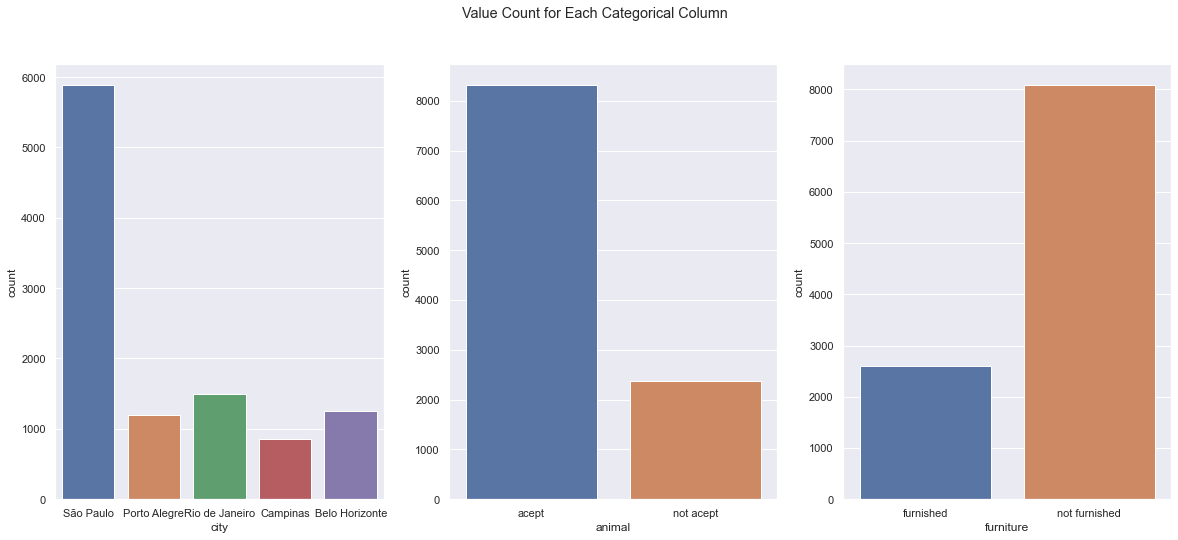

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle("Value Count for Each Categorical Column")
for index, col in enumerate(cat_cols):
    sns.countplot(ax=axs[index], data=houses, x=col)
plt.show()

From these plots, we can see that there are only two categories in both the 'animal' column and the 'furniture' column. This will make it quite easy to enocode the columns later on. This kind of strict binary indication can worsen the performance of our model, however. This is especially the case with the 'furniture' column, because the variable does not indicate how well the apartment is furnished. 

The dataset mostly contains houses/apartments located in Sao Paulo, which makes sense because Sao Paulo is the most popoulous city in Brazil. The fact that Sao Paulo is the most popoulous city can indicate that the 'city' column will most-likely affect the rent amount, due to the higher demand present in certain cities.

Let's start preprocessing our data and selecting the features for our model.

### Data Preprocessing and Feature Selection

Now, we will prepare the dataset for machine learning. This will be done in several stages:
1. Split the data into the training and testing datasets
2. Check for missing data within the dataset and determine how to handle it
3. Identify outliers in the dataset and determine whether to keep or remove them
4. Select the best features for our model

#### Splitting the Data

We will split the data into two datasets in order to first train the data and then use the remaining data to test our model. It is essential to ensure that the data split is the first step of data preprocessing in order to avoid data leakage in our analysis. I will use the standard 80-20 split, since this is widely used in the data science industry.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

#### Missing Data

Our second step in datapreprocessing is to find any missing data within the dataset and decide how to handle it. I will approach this task by looking at the dataset as a whole and find the observations which contain np.NaN. Afterwards, I will take a look at each column individually to ensure that there are no values which could also indicate observations with missing values. 

In [52]:
X_train_missing = [col for col in X_train.columns if X_train[col].isnull().any()]
X_test_missing = [col for col in X_test.columns if X_test[col].isnull().any()]
y_train_missing = [col for col in y_train.columns if y_train[col].isnull().any()]
y_test_missing = [col for col in y_test.columns if y_test[col].isnull().any()]

In [53]:
print("Columns with missing values in X_train:", X_train_missing)
print("Columns with missing values in X_test:", X_test_missing)
print("Columns with missing values in y_train:", y_train_missing)
print("Columns with missing values in y_test:", y_test_missing)

Columns with missing values in X_train: []
Columns with missing values in X_test: []
Columns with missing values in y_train: []
Columns with missing values in y_test: []


As you can see, no columns in any of the dataframes have any observations with np.NaN. This, however, does not necessarily confirm that there are no missing observations in the dataset, since they can be denoted by different values. So, let's take a look at each column individually and try to identify any missing values. 

As we saw previously in our barplots, there are no 'strange' values in our categorical columns, since all of the unique values make sense within the categorical columns. As such, we can confirm that these columns have no missing values, so we will instantly move on to the numerical columns.

The most obvious way to represent missing values for variables like 'area', 'room', or 'bathroom' would be to use non-positive values, since zero or negative values would make no sense within those columns. Thus, we will attempt to find any observations with non-positive values in 'area', 'room', and 'bathroom' columns.

In [54]:
# Checking for potentially missing values in X_train
X_train_area = X_train["area"] <= 0
X_train_rooms = X_train["rooms"] <= 0
X_train_bathroom = X_train["bathroom"] <= 0
X_train[(X_train_area) | (X_train_rooms) | (X_train_bathroom)]

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture


In [55]:
# Checking for potentially missing values in X_test 
X_test_area = X_test["area"] <= 0
X_test_rooms = X_test["rooms"] <= 0
X_test_bathroom = X_test["bathroom"] <= 0
X_test[(X_test_area) | (X_test_rooms) | (X_test_bathroom)]

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture


As you can see above, no observation contains a non-positive value in the 'area', 'rooms', and 'bathroom' columns in both the training and the testing data. This allows us to confirm that these columns do not have any missing values.

Now, we should take a closer look at the 'parking spaces' column. First, we will filter for strictly negative values, since it's possible that certain houses or apartments come with no parking spaces; however, we will still take a look at the observations that contain zero in the 'parking spaces' column and take a closer look at those values.

In [56]:
X_train[X_train["parking spaces"] < 0]

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture


In [57]:
X_test[X_test["parking spaces"] < 0]

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture


As you can see, there are no strictly negative values in the 'parking spaces' column in neither the training nor the testing dataset, so let's move on to the observations, which contain no parking spaces and create a statistical summary for those records.

In [58]:
X_train[X_train["parking spaces"] == 0].describe()

,area,rooms,bathroom,parking spaces,floor
count,2156.000000,2156.000000,2156.000000,2156.0,2156.000000
mean,78.349258,1.713358,1.352505,0.0,4.094620
std,280.720335,0.926750,0.787989,0.0,4.715906
min,11.000000,1.000000,1.000000,0.0,0.000000
25%,36.000000,1.000000,1.000000,0.0,1.000000
50%,52.000000,1.000000,1.000000,0.0,3.000000
75%,80.000000,2.000000,1.000000,0.0,6.000000
max,12732.000000,8.000000,7.000000,0.0,32.000000


In [59]:
X_test[X_test["parking spaces"] == 0].describe()

,area,rooms,bathroom,parking spaces,floor
count,527.000000,527.000000,527.000000,527.0,527.000000
mean,81.586338,1.781784,1.472486,0.0,4.060721
std,82.480990,0.949189,1.001283,0.0,4.824300
min,15.000000,1.000000,1.000000,0.0,0.000000
25%,39.500000,1.000000,1.000000,0.0,1.000000
50%,56.000000,1.000000,1.000000,0.0,2.000000
75%,90.000000,2.000000,2.000000,0.0,6.000000
max,700.000000,7.000000,10.000000,0.0,25.000000


2156 observations in the training dataset have no parking spaces. Based on the mean value, as well as the median and the first and third quartile values, it seems plausible that such observations would contain no parking spaces, since they represent relatively small houses/apartments, which would not necessarily come with parking spaces. If we take a closer look at the maximum values, however, we can see that those values represent large houses/apartments, and it does not make sense for them to have no parking spaces due to their size. This is also the case for the testing dataset, which mostly consists of small houses/apartments, but also has large houses/apartments, which most-likely would have parking spaces. Based on this statistical summary, we can conclude that the parking spaces column most-likely contains missing values.

We can deal with this missing data in the following ways: remove it, impute it, or interpolate it. Whichever method we pick, it does not make sense to apply this to all of the observations with the value of zero in the parking spaces column. If we choose to remove all of those values, we would lose a large chunk of the training dataset, which is something we cannot afford. If we choose to impute all of the values, we would get rid of the missing data, but we would also invalidate a lot of observations with most-likely accurate values, possibly negatively affecting the accuracy of our model. Finally, if we choose to interpolate all of the observations, we could not only invalidate certain records, but we would also need to ensure there's a solid relationship between the 'parking spaces' variable and other variables in the dataset in order to accurately interpolate the missing values. As such, we need to apply one of the above methods to only certain observations in order to maintain a high degree of accuracy in our dataset.

Now, we need to determine which observations we will apply the method to. For this, I am going to be using the numeric outlier technique. Although this is an outlier detection technique, I think it could be used here appropriately to identify observations that are the likeliest to contain missing values in the 'parking spaces' column. I am going to filter the training dataset to find only observations with no parking spaces. Then, I will look at the distribution of the 'rooms' column, since it is, intuitively, most closely connected to the 'parking spaces' variable. I will calculate the 'upper bound' for the 'rooms' column using the formula $q_3 + IQR*1.5$; this value corresponds to the top whisker in a boxplot. Any observation which contains a value above the upper bound in the 'rooms' column will be deemed an outlier, indicating that it most-likely contains missing data.

Before we put this method to use, let's take a look at the dat distribution of the 'area' column to confirm that this method makes sense.

[Text(0.5, 1.0, "Boxplot of the 'area' column")]

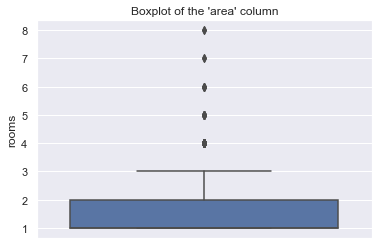

In [60]:
no_parking_train = X_train[X_train["parking spaces"] == 0]
sns.boxplot(y="rooms", data=no_parking_train).set(title="Boxplot of the 'area' column")

The above boxplot shows that this method makes sense, since a lot of observations with relatively high amount of rooms, which contain no parking spaces, however, were identified as outliers. Let's apply this method to our dataset and decide how to handle those values in the dataset.

In [61]:
k = 1.5
q1 = no_parking_train["rooms"].quantile(0.25)
q3 = no_parking_train["rooms"].quantile(0.75)
iqr = q3 - q1
threshold = q3 + k*iqr
above_threshold_train = no_parking_train[no_parking_train["rooms"] > threshold]
len(above_threshold_train) / len(X_train) * 100

1.052262364082778

As you can see, approximately 1.05% of our training dataset most-likely contains missing values in the "parking spaces" column. We should also check how many similar observations are present in the testing dataset using the same threshold. The reason why I am using the same threshold is to avoid data leakage in our analysis. 

In [62]:
no_parking_test = X_test[X_test["parking spaces"] == 0]
above_threshold_test = no_parking_test[no_parking_test["rooms"] > threshold]
len(above_threshold_test) / len(X_test) * 100

1.3557737260402059

Similarly to the training dataset, approximately 1.35% of observations most-likely contain missing values in the "parking spaces" column. I don't think imputing makes sense in this case, because the distribution of the 'rooms' column is quite wide, as we saw in the boxplot, whcih means imputation will probably lead to incorrect data. We could trying to interpolate the column, but first we need to check how strong the relationship is between the 'parking spaces' column and other features, specifically the 'area' and 'rooms' variables. 

In [63]:
X_train[["area", "rooms", "parking spaces"]].corr()

,area,rooms,parking spaces
area,1.000000,0.177574,0.178443
rooms,0.177574,1.000000,0.623027
parking spaces,0.178443,0.623027,1.000000


The relationship between the 'area' and 'parking spaces' columns is quite weak, so we cannot use the 'area' column for interpolation. The relationship between the 'rooms' and 'parking spaces' columns is moderately strong, but I don't think a single column is enough to guarantee accurate interpolation. As such, I think it is best to simply remove the observations we detected above, since we can afford to lose just over 1% of both the training and testing datasets.

In [64]:
X_train.drop(above_threshold_train.index, inplace=True)
X_test.drop(above_threshold_test.index, inplace=True)

In [65]:
y_train.drop(above_threshold_train.index, inplace=True)
y_test.drop(above_threshold_test.index, inplace=True)

Finally, let's check our target column for any missing data. Similarly to the previous analysis, we will look for non-positive values, since they make no sense in the 'rent amount' variable. 

In [66]:
y_train[y_train["rent amount (R$)"] < 1]

,rent amount (R$)


In [67]:
y_test[y_test["rent amount (R$)"] < 1]

,rent amount (R$)


As you can see, there are no non-positive values in the target variable in both the training and testing dataset, and so we can confirm that the target variable contains no missing values.

Now that we are done working with missing values, let's move on to encoding all of the categorical variables in our dataset.

#### Categorically Encoding Data
We will now move on to encoding the categorical variables in the dataset in order to prepare it for further preprocessing. Let's begin by looking at the categorical columns we will have to deal with and deciding how to encode.

In [68]:
houses.select_dtypes(exclude=np.number).columns.tolist()

['city', 'animal', 'furniture']

We will start by encoding the 'animal' and 'furniture' columns. As we saw previously, those columns only have two unique values. The 'animal' variable indicates whether the house/apartment accepts animals or not. Similarly, the 'furniture' column indicates if the house/apartment is furnished or not. As such, we will make the two columns binary. This means that if the apartment accepts animals or is furnished, it will contain a 1 in its respective column, and 0 otherwise.

In [69]:
X_train["animal"] = X_train["animal"] == "acept"
X_train["animal"] = X_train["animal"].astype(int)
X_test["animal"] = X_test["animal"] == "acept"
X_test["animal"] = X_test["animal"].astype(int)

In [70]:
X_train["furniture"] = X_train["furniture"] == "furnished"
X_train["furniture"] = X_train["furniture"].astype(int)
X_test["furniture"] = X_test["furniture"] == "furnished"
X_test["furniture"] = X_test["furniture"].astype(int)

Now, let's move on to the 'city' column. As we saw previously, the column contains 5 different Brazilian cities. Since there are only 5 of them and the data is not ordinal, we should encode the column using the One-Hot Encoding method. Since we are using this method, we should check that the 'city' column contains the same values for both the training and testing datasets.

In [71]:
len(X_train["city"].unique()) == len(X_test["city"].unique())

True

The two unique lists are equal, so we don't need to focus on handling unknown values.

In [72]:
oh_encoder = OneHotEncoder(sparse=False)
ohe_city_train = pd.DataFrame(oh_encoder.fit_transform(X_train[["city"]]))
ohe_city_train.index = X_train.index
ohe_city_test = pd.DataFrame(oh_encoder.transform(X_test[["city"]]))
ohe_city_test.index = X_test.index

In [73]:
X_train.drop("city", inplace=True, axis=1)
X_test.drop("city", inplace=True, axis=1)

In [74]:
X_train = X_train.merge(ohe_city_train, right_index=True, left_index=True)
X_test = X_test.merge(ohe_city_test, right_index=True, left_index=True)

#### Working with Outliers
We will now move on to identifying outliers in our dataset. To do so, we are going to use Mahalanobis Distance. Mahalanobis Distance is a measure of distance between a point and its distribution. It uses the inverse of a covariance matrix of variables in the combination with the data's center to find the distance, which means that it detects outliers based on the pattern of data points. If you would like to find out more about Mahalanobis Distance or other outlier detection techniques, please check out my [Outlier Detection Techniques Notebook](https://www.kaggle.com/karimzakir02/outlier-detection-techniques), which talks about Mahalanobis Distance and three other outlier detection methods.

Mahalanobis Distance is great for this dataset, since our data is multivariate. Additionally, Mahalanobis Distance will adapt to our data's "wide" distribution, making it a better alternative to other techniques like Euclidean Distance, which does not consider the distribution of the data. 

As a cut-off value, I am going to be using the Chi-Square distribution cut-off with the 0.01 significance value, since I am interested in finding the most extreme points in the dataset. To avoid data leakage, we are going to find the cut-off point for the training dataset only and then apply the same value for the testing dataset.

After identifying the outliers in our dataset, we will develop a method in order to determine if those outliers should be removed or kept in the datasets.

In [75]:
training_dataset = X_train.merge(y_train, left_index=True, right_index=True)
inv_cov = np.linalg.matrix_power(training_dataset.cov(), -1)
mean = np.mean(training_dataset)
training_dataset["mahalanobis_distance"] = np.NaN

In [76]:
for index, row in training_dataset.iterrows():
    values = row[0:13]
    training_dataset.loc[index, "mahalanobis_distance"] = mahalanobis(values, mean, inv_cov)**2

In [77]:
mahalanobis_threshold = chi2.ppf(0.99, training_dataset.shape[1] - 1)
mahalanobis_outliers = training_dataset[training_dataset["mahalanobis_distance"] > mahalanobis_threshold]
len(mahalanobis_outliers)

206

We have identified 204 outliers, which is quite a lot, especially if we have to go through them one by one. As such, we need to develop a systematic approach in order to determine whether we need to remove a particular outlier or not. Let's take a look at a few observations in order to determine what kind of approach we should adapt. 

In [78]:
mahalanobis_outliers.sample(n=20, random_state=45)

,area,rooms,bathroom,parking spaces,floor,animal,furniture,0,1,2,3,4,rent amount (R$),mahalanobis_distance
6185,455,4,5,4,5,1,0,0.0,0.0,0.0,0.0,1.0,19500,28.067459
9833,200,3,2,2,3,1,0,0.0,0.0,0.0,1.0,0.0,15000,30.710426
6851,220,3,2,8,0,1,0,0.0,0.0,0.0,0.0,1.0,4335,39.170104
6132,500,3,6,0,0,1,0,0.0,0.0,0.0,0.0,1.0,6400,30.978099
5178,400,10,9,8,0,1,0,0.0,0.0,0.0,0.0,1.0,8330,56.213184
369,200,2,4,3,12,1,0,1.0,0.0,0.0,0.0,0.0,15000,34.187035
5904,163,3,5,3,20,1,0,0.0,1.0,0.0,0.0,0.0,9800,28.362840
752,341,10,6,7,0,1,0,1.0,0.0,0.0,0.0,0.0,5500,63.434045
3071,309,4,7,8,0,1,0,0.0,0.0,0.0,0.0,1.0,8000,28.260836
811,293,6,2,3,0,1,0,1.0,0.0,0.0,0.0,0.0,2600,27.721741


What we can see based on these outliers is that certain values do not make sense in the context of the observation. For instance, look at the observations 770 and 640 in the table. While they have drastically differing areas, they have the same 'rent amount (R$)' values. As such, it becomes unclear which observation contains a wrong value and which one should be removed. 

This suggests that we should take a look at observations with a similar value to an identified outlier in a particular variable and check whether all of the other variables are similar to the variables in our identified outlier. This will take a lot of time to do for over 200 observations. There's also the issue of deciding how similar should the variables be. As such, we need to develop a system, which can help us identify the most extreme observations in our dataset. 

We will go through each observation manually and take a quick glance at it to understand which variable caused the observation to have high Mahalanobis Distance; I will refer to this variable as the 'off' variable. We will record this information. While slow at first, the benefit of this is that we can instantly remove any observations which contain obvious data-entry errors. This will also allow me to ensure that applying this method makes sense for as many identified outliers as possible. Afterwards, we will get the mean values for the 'off' variable for similar observations, but not take into consideration the outlier itself. We will then determine whether value in the 'off' variable is a numeric outlier relative to the values in the variable of similar values, using the numeric outlier technique.

I won't display all of the observations identified as outliers when finding the 'off' variable, because it will take too much space; I will show just the first few.

In [79]:
mahalanobis_outliers.sort_values("mahalanobis_distance", ascending=False).head()

,area,rooms,bathroom,parking spaces,floor,animal,furniture,0,1,2,3,4,rent amount (R$),mahalanobis_distance
2397,46335,4,8,5,11,1,1,1.0,0.0,0.0,0.0,0.0,8500,6150.475733
2562,80,3,2,2,301,1,0,1.0,0.0,0.0,0.0,0.0,2600,2350.156938
5915,24606,5,4,4,12,1,0,0.0,0.0,0.0,0.0,1.0,8100,1733.764721
9241,12732,3,2,0,3,1,0,0.0,1.0,0.0,0.0,0.0,1600,481.464275
2182,700,4,7,8,0,1,0,0.0,0.0,0.0,0.0,1.0,45000,224.529723


In [80]:
remove_instantly = [2397, 2562, 5915, 2182, 2619, 9012]
outliers_dict = {6947: "rent amount (R$)", 5445: "parking spaces", 4813: "rent amount (R$)", 1639: "rooms",
                 10619: "rent amount (R$)", 9565: "rooms", 1810: "rent amount (R$)", 752: "rent amount (R$)", 5178: "rooms", 1946: "parking spaces",
                 4829: "parking spaces", 9464: "parking spaces", 9788: "parking spaces", 10125: "parking spaces", 2055: "rooms", 9857: "parking spaces",
                 5525: "rent amount (R$)", 3066: "bathroom", 9989: "rooms", 5998: "rent amount (R$)", 9442: "parking spaces", 8380: "bathroom", 
                 1130: "bathroom", 9479: "rent amount (R$)", 1253: "rent amount (R$)", 1780: "parking spaces", 9568: "parking spaces",
                 911: "rent amount (R$)", 6589: "bathroom", 6014: "parking spaces", 1334: "parking spaces", 2069: "rent amount (R$)", 
                 8943: "parking spaces", 2845: "parking spaces", 4634: "rooms", 4088: "rent amount (R$)", 2867: "rooms", 671: "rent amount (R$)",
                 6423: "rent amount (R$)", 2398: "rooms", 3853: "rent amount (R$)", 5685: "rent amount (R$)", 2642: "rent amount (R$)",
                 1764: "rent amount (R$)", 6384: "parking spaces", 10590: "parking spaces", 7226: "rent amount (R$)", 1138: "rent amount (R$)",
                 6851: "parking spaces", 801: "parking spaces", 9822: "parking spaces", 5293: "rent amount (R$)", 10376: "parking spaces",
                 4497: "rent amount (R$)", 7441: "rent amount (R$)", 4541: "rent amount (R$)", 2106: "rent amount (R$)", 1020: "rent amount (R$)",
                 10353: "rent amount (R$)", 1571: "rent amount (R$)", 707: "parking spaces", 6954: "parking spaces", 10256: "rent amount (R$)",
                 4027: "rent amount (R$)", 1838: "parking spaces", 7597: "rent amount (R$)", 510: "parking spaces", 3348: "parking spaces",
                 8334: "rooms", 8399: "rent amount (R$)", 7886: "parking spaces", 4621: "parking spaces", 9995: "parking spaces",
                 3926: "rent amount (R$)", 2414: "rent amount (R$)", 317: "parking spaces", 8435: "rent amount (R$)", 369: "rent amount (R$)",
                 7192: "rent amount (R$)", 4617: "parking spaces", 5528: "rent amount (R$)", 1470: "rent amount (R$)", 1877: "rent amount (R$)",
                 9749: "parking spaces", 531: "rooms", 952: "parking spaces", 1452: "rent amount (R$)", 8435: "parking spaces", 9856: "rent amount (R$)",
                 7192: "rent amount (R$)", 531: "rooms", 1877: "rent amount (R$)", 831: "parking spaces", 2275: "parking spaces",
                 534: "rent amount (R$)", 4547: "rent amount (R$)", 1470: "rooms", 863: "parking spaces", 816: "rent amount (R$)",
                 9775: "rent amount (R$)", 6482: "parking spaces", 3485: "parking spaces", 6073: "rooms", 9663: "rent amount (R$)", 
                 9663: "rent amount (R$)", 7675: "rent amount (R$)", 8858: "rent amount (R$)", 10108: "rent amount (R$)", 6506: "rent amount (R$)",
                 5002: "rent amount (R$)", 7433: "parking spaces", 1041: "rent amount (R$)", 9145: "rent amount (R$)", 4594: "parking spaces",
                 1697: "parking spaces", 299: "rooms", 1568: "parking spaces", 6202: "bathroom", 10558: "parking spaces", 1159: "parking spaces", 
                 2627: "rent amount (R$)", 5288: "rent amount (R$)", 8356: "rent amount (R$)", 10082: "rent amount (R$)", 6219: "rent amount (R$)",
                 1351: "rooms", 9363: "rent amount (R$)", 456: "rooms", 10558: "rent amount (R$)", 1159: "parking spaces", 2627: "rent amount (R$)",
                 5288: "rent amount (R$)", 8356: "rent amount (R$)", 10082: "rent amount (R$)", 6219: "rent amount (R$)", 1351: "rooms",
                 9363: "rent amount (R$)", 456: "rooms", 6996: "rent amount (R$)", 3416: "rent amount (R$)", 607: "rent amount (R$)", 
                 8080: "rent amount (R$)", 4170: "rent amount (R$)", 7907: "rent amount (R$)", 10225: "rent amount (R$)", 9948: "parking spaces",
                 4681: "rent amount (R$)", 10530: "rent amount (R$)", 4025: "rent amount (R$)", 6457: "rooms", 1491: "rent amount (R$)", 
                 676: "parking spaces", 2624: "rent amount (R$)", 680: "rent amount (R$)", 9977: "rent amount (R$)",
                 4952: "rent amount (R$)", 6328: "rent amount (R$)", 2087: "rent amount (R$)", 5105: "rent amount (R$)", 3071: "parking spaces",
                 6185: "rent amount (R$)", 2859: "rent amount (R$)", 595: "rooms", 2709: "rent amount (R$)", 
                 5763: "rent amount (R$)", 5904: "rent amount (R$)"}

In [81]:
training_dataset.drop(remove_instantly, inplace=True)
X_train.drop(remove_instantly, inplace=True)
y_train.drop(remove_instantly, inplace=True)

In [82]:
# .loc()
k = 1.5
to_remove = []
for row_key, off_column in outliers_dict.items():
    row_area = mahalanobis_outliers.loc[row_key]["area"]
    off_value = mahalanobis_outliers.loc[row_key][off_column]
    neighborhood = training_dataset[(training_dataset["area"] > max(0, row_area-50)) & \
                                    (training_dataset["area"] < row_area+50)].drop(row_key)
    quantiles = neighborhood[off_column].quantile([0.25, 0.75])
    q1 = quantiles.iloc[0]
    q3 = quantiles.iloc[1]
    iqr = q3 - q1
    upper_bound = q3 + k*iqr
    lower_bound = q1 - k*iqr
    if off_value < lower_bound or off_value > upper_bound:
        to_remove.append(row_key)
        training_dataset.drop(row_key, inplace=True)

In [83]:
len(to_remove)

53

In [84]:
X_train.drop(to_remove, inplace=True)
y_train.drop(to_remove, inplace=True)

We have removed 53 observations from our training datasets. Let's now take a look at our test dataset. We will be using the same method and use the same Mahalanobis Threshold, mean, and covariance matrix in order to avoid data leakage. 

In [85]:
test_dataset = X_test.merge(y_test, left_index=True, right_index=True)
test_dataset["mahalanobis_distance"] = np.NaN

In [86]:
test_dataset.head()

,area,rooms,bathroom,parking spaces,floor,animal,furniture,0,1,2,3,4,rent amount (R$),mahalanobis_distance
358,95,3,2,2,7,1,0,0.0,0.0,0.0,1.0,0.0,2300,NaN
5191,104,3,2,2,1,0,0,0.0,0.0,0.0,0.0,1.0,3800,NaN
4501,55,1,1,1,9,0,1,0.0,0.0,0.0,0.0,1.0,2860,NaN
7555,80,2,2,0,4,1,0,0.0,0.0,0.0,1.0,0.0,4100,NaN
62,70,2,1,1,13,1,0,0.0,0.0,0.0,0.0,1.0,2150,NaN


In [87]:
for index, row in test_dataset.iterrows():
    values = row[0:13]
    test_dataset.loc[index, "mahalanobis_distance"] = mahalanobis(values, mean, inv_cov)**2

In [88]:
test_mahalanobis_outliers = test_dataset[test_dataset["mahalanobis_distance"] > mahalanobis_threshold]
len(test_mahalanobis_outliers)

55

We have identified 53 outliers, but we will now check how many of them we should remove by conducting the same analysis as previously.

In [89]:
test_mahalanobis_outliers.sort_values("mahalanobis_distance", ascending=False).head()

,area,rooms,bathroom,parking spaces,floor,animal,furniture,0,1,2,3,4,rent amount (R$),mahalanobis_distance
7835,439,13,4,3,0,1,0,0.0,0.0,0.0,1.0,0.0,15000,177.605001
7748,350,3,3,3,0,1,0,0.0,0.0,0.0,0.0,1.0,30000,114.540670
5694,64,2,2,2,51,1,0,0.0,1.0,0.0,0.0,0.0,1900,69.623445
9021,458,8,10,4,0,1,0,1.0,0.0,0.0,0.0,0.0,7000,64.029299
7826,83,2,1,8,0,1,0,0.0,1.0,0.0,0.0,0.0,4550,59.664620


In [90]:
test_outliers_dict = {7835: "rooms", 7748: "rent amount (R$)", 3772: "parking spaces", 3559: "parking spaces", 3772: "parking spaces", 
                      7826: "parking spaces",  10472: "rooms", 8628: "rent amount (R$)", 9914: "bathroom", 143: "rent amount (R$)", 
                      9021: "rent amount (R$)", 421: "rent amount (R$)", 1528: "rent amount (R$)", 5660: "rent amount (R$)", 3251: "parking spaces", 
                      8312: "parking spaces", 6101: "parking spaces", 3863: "parking spaces", 2456: "rooms", 628: "rent amount (R$)", 
                      8307: "parking spaces", 10587: "rent amount (R$)", 7742: "rent amount (R$)", 2576: "rent amount (R$)", 2338: "rent amount (R$)", 
                      4217: "rooms", 6138: "parking spaces", 1500: "bathroom", 2495: "rooms", 4224: "rent amount (R$)", 8966: "rent amount (R$)", 
                      1426: "rent amount (R$)", 1676: "parking spaces", 5945: "parking spaces", 5564: "rooms", 4037: "rent amount (R$)", 
                      9204: "bathroom", 4993: "rent amount (R$)", 8874: "parking spaces",  7802: "rent amount (R$)", 1976: "rent amount (R$)", 
                      6777: "rent amount (R$)", 4913: "rent amount (R$)", 7474: "rent amount (R$)", 9797: "rent amount (R$)", 2998: "rent amount (R$)", 
                      8362: "rent amount (R$)", 2315: "rent amount (R$)", 2337: "rent amount (R$)",}

In [91]:
k = 1.5
to_remove_test = []
for row_key, off_column in test_outliers_dict.items():
    row_area = test_mahalanobis_outliers.loc[row_key]["area"]
    off_value = test_mahalanobis_outliers.loc[row_key][off_column]
    neighborhood = training_dataset[(training_dataset["area"] > max(0, row_area-50)) & \
                                    (training_dataset["area"] < row_area+50)]
    quantiles = neighborhood[off_column].quantile([0.25, 0.75])
    q1 = quantiles.iloc[0]
    q3 = quantiles.iloc[1]
    iqr = q3 - q1
    upper_bound = q3 + k*iqr
    lower_bound = q1 - k*iqr
    if off_value < lower_bound or off_value > upper_bound:
        to_remove_test.append(row_key)

In [92]:
len(to_remove_test)

14

In [93]:
X_test.drop(to_remove_test, inplace=True)
y_test.drop(to_remove_test, inplace=True)

We have removed 14 observations from our training dataset. It is impossible to guarantee whether we have removed observations with data-entry errors; however, based on the method used here, we can conclude that those observations were most likely data-entry errors or incredibly rare outliers, which are simply not noteworthy enough in order to be considered in our model due to their distance from majority of the data and their rarity.

#### Feature Selection

We will now select the best features for our model by seeing whether the potential features have any effect on the target variable

In [94]:
training_dataset = X_train.merge(y_train, left_index=True, right_index=True)

**The 'area' column:**

The 'area' column indicates how big an apartment or a house is. Intuitively, the area variable should have a positive correlation with the rent amount column, since a bigger apartment would have a higher price. Let's take a closer look at our observations and make sure that the same rule applies to our data.

<AxesSubplot:xlabel='area', ylabel='rent amount (R$)'>

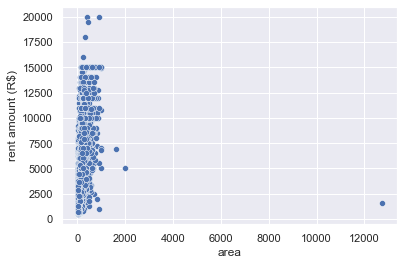

In [95]:
sns.scatterplot(data=training_dataset, x="area", y="rent amount (R$)")

Based on this scatterplot, we can see that there' a moderately strong positive correlation. There are several points, though, that do not strictly follow this relationship, weaking the correlation between the potential feature and the target variable. This suggests that we should not necessarily use linear regression as our model. Additionally, there's a point which is incredibly far from the rest of the data. Surprisingly, our outlier detection technique did not catch this point. Let's take a closer look at this observation

In [96]:
outlier_index = training_dataset[training_dataset["area"] > 12000].index[0]
outlier_index in mahalanobis_outliers

False

Indeed, this point was not deemed an outlier by Mahalanobis Distance; however, as the scatterplot shows, this point is quite far from the rest of our data and is most-likely a data-entry error. Let's remove it from our training dataset.

In [97]:
training_dataset.drop(outlier_index, inplace=True)
X_train.drop(outlier_index, inplace=True)

In [98]:
y_train.drop(outlier_index, inplace=True)

Let's now quantify the relationship between 'area' and the target variable to confirm that the columns are related to each other. 

In [99]:
training_dataset[["area", "rent amount (R$)"]].corr()

,area,rent amount (R$)
area,1.000000,0.674866
rent amount (R$),0.674866,1.000000


The above table confirms that the relationship is somewhat strong and positive. I think the Pearson correlation is high enough in order for the variable to be used in the model. As such, we are going to keep it.

**The 'city' column:**

The second column we will check is the 'city' column, which indicates where the apartment/house is located. 

Intuitively, it would make sense that apartments/cities in certain cities would be more expensive, as certain cities could have more attractive prospects, causing the population to shift towards those cities, driving up the real estate prices there. Let's check whether this is true for the houses in our dataset. Earlier, we have one hot encoded this variable. For convinience, we are going to use the original city column.

We are going to determine whether the mean rent amount in a particular city is higher when compared to other cities in order to understand if there are is a relationship between the two variables.

In [100]:
training_dataset = training_dataset.merge(houses["city"], how="inner", left_index=True, right_index=True)

<AxesSubplot:xlabel='city', ylabel='rent amount (R$)'>

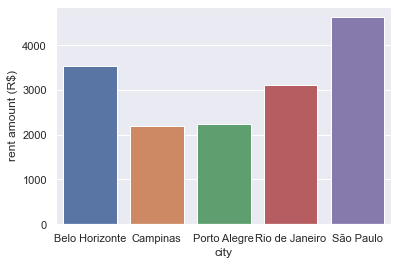

In [101]:
city_mean_rent = training_dataset.groupby("city")[["rent amount (R$)"]].mean()
sns.barplot(data=city_mean_rent, x=city_mean_rent.index, y="rent amount (R$)")

The above plot shows the clear difference in the average rent costs in each of the cities. However, without further analysis, it could be argued that the difference is potentially to area differences in the cities. To ensure this is not the case, let's also plot the average area next to the above plot.

In [102]:
city_mean_area = training_dataset.groupby("city")[["area"]].mean()

[Text(0.5, 1.0, 'Average Area of Apartments/Houses in Brazilian Cities')]

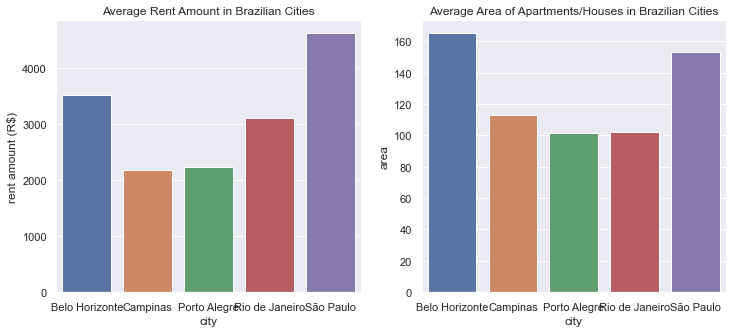

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
mean_cities = training_dataset.groupby("city")[["rent amount (R$)", "area"]].mean()
sns.barplot(data=city_mean_rent, x=city_mean_rent.index, y="rent amount (R$)", ax=axs[0]).set(title="Average Rent Amount in Brazilian Cities")
sns.barplot(data=city_mean_area, x=city_mean_area.index, y="area", ax=axs[1]).set(title="Average Area of Apartments/Houses in Brazilian Cities")

When looking at the two plots side by side, we can confidently conclude that the 'city' variable affects the target variable. For instance, let's take a closer look at Belo Horizonte and Sao Paulo bar plots. Although the real estate is bigger on average in Belo Horizonte than in Sao Paulo, the rent is still higher in Sao Paulo, which contradicts the positive relationship between the 'area' column and the target variable that we found earlier. As such, it is most-likely that the 'city' variable does affect the target variable, and we should use it within our model.

**The 'rooms' column:**

The 'rooms' column indicates how many rooms the apartment has. It is hard to intutively determine whether this variable should be a feature or not. On the one hand, more rooms can indicate more living space, which can drive up the price of an apartment. On the other hand, more rooms can simply indicate more area within the apartment, meaning that the 'rooms' variable could just be a proxy for the 'area' variable, which is not worth including in our model. 

However, apartments/houses with similar areas can have different amount of rooms, suggesting that the 'rooms' variable does not always act like a proxy variable. So, the real question now is whether the amount of rooms for apartments/houses with similar areas affects the target variable. We will answer this question by looking at apartments/houses with similar 'area' values, but different 'rooms' values and seeing whether the price is affected or not. 

We will do this by taking segments of the training dataset with similar area but different amount of rooms and measuring the difference in average rent amounts. 

In [104]:
counter = 100
counters = []
rent_diffs_2_3 = []
rent_diffs_3_4 = []
area_diffs = []
while counter < 400:
    counters.append(counter)
    training_segment = training_dataset[(training_dataset["area"] < counter+5) & (training_dataset["area"] >= counter)]
    rooms_2 = training_segment[training_segment["rooms"] == 2]
    rooms_3 = training_segment[training_segment["rooms"] == 3]
    rooms_4 = training_segment[training_segment["rooms"] == 4]
    rooms_2_rent = rooms_2["rent amount (R$)"].mean()
    rooms_3_rent = rooms_3["rent amount (R$)"].mean()
    rooms_4_rent = rooms_4["rent amount (R$)"].mean()
    rent_diffs_2_3.append(rooms_2_rent - rooms_3_rent)
    rent_diffs_3_4.append(rooms_3_rent - rooms_4_rent)
    counter += 5

In [105]:
to_plot_2_3 = pd.DataFrame({"area": counters, "diffs": rent_diffs_2_3}, columns=["area", "diffs"])
to_plot_2_3["label"] = "Differences in Rent between 2 and 3 rooms"
to_plot_3_4 = pd.DataFrame({"area": counters, "diffs": rent_diffs_3_4}, columns=["area", "diffs"])
to_plot_3_4["label"] = "Differences in Rent between 3 and 4 rooms"
to_plot = pd.concat([to_plot_2_3, to_plot_3_4], ignore_index=True)

<AxesSubplot:xlabel='area', ylabel='diffs'>

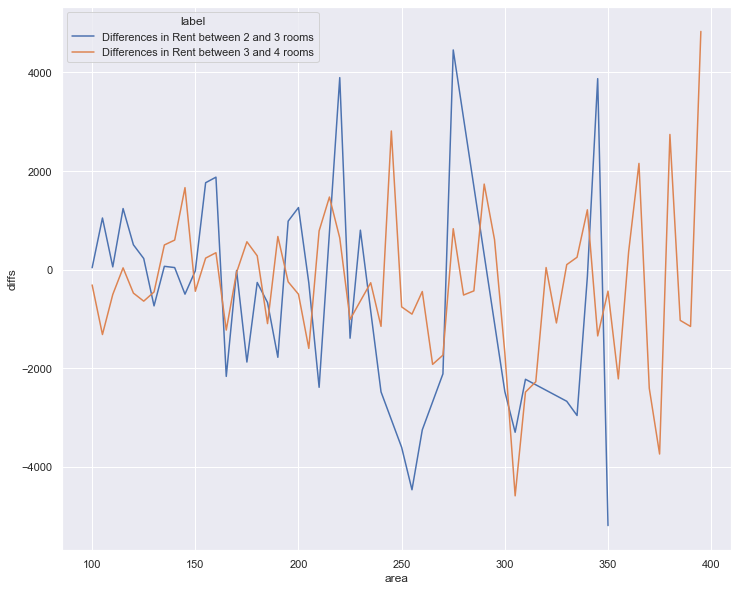

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.lineplot(x="area", y="diffs", hue="label", data=to_plot, ax=ax)

As you can see, even with lower areas, the difference between apartments with different amount of rooms reaches as high as 2000 BRL. The difference becomes even larger as the area increases. Based on the y-axis, the difference can be quite high at certain point, so our results are most likely statistically signifcant and are not there due to randomness solely. As such, we can conclude that the 'rooms' variable is a useful feature for our dataset and is not solely a proxy variable for the 'area' column.

**The 'bathroom' column:**

The 'bathroom' column indicates the amount of bathroom in an apartment/house. Similarly to the 'rooms' column, it is unclear whether this column truly affects the target variable or whether it acts as a proxy variable to the 'area' and the 'rooms' columns. As such, we will conduct a similar experiment with this column as we did with the "rooms column"

In [107]:
counter = 100
counters = []
rent_diffs = []
room_diffs = []
while counter < 250:
    counters.append(counter)
    training_segment = training_dataset[(training_dataset["area"] < counter+10) & (training_dataset["area"] >= counter)]
    bathroom_2 = training_segment[training_segment["bathroom"] == 2]
    bathroom_3 = training_segment[training_segment["bathroom"] == 3]
    bathroom_2_rooms = bathroom_2["rooms"].mean()
    bathroom_3_rooms = bathroom_3["rooms"].mean()
    room_diffs.append(bathroom_2_rooms - bathroom_3_rooms)
    bathroom_2_rent = bathroom_2["rent amount (R$)"].mean()
    bathroom_3_rent = bathroom_3["rent amount (R$)"].mean()
    rent_diffs.append(bathroom_2_rent - bathroom_3_rent)
    counter += 10

[Text(0.5, 0, 'Area'), Text(0, 0.5, 'Room Differences')]

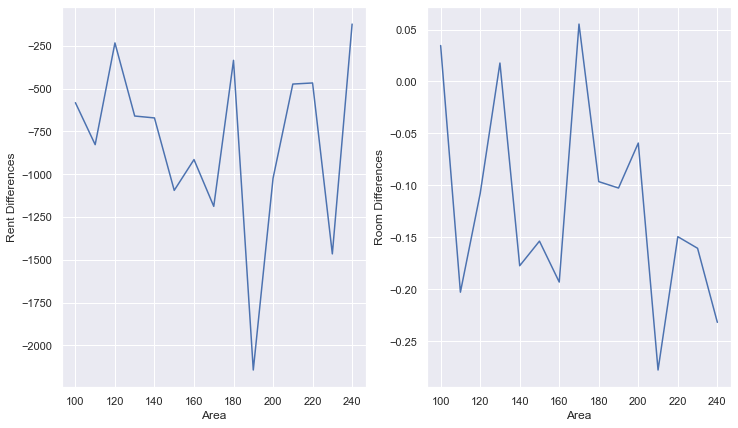

In [108]:
fig, axs = plt.subplots(1, 2, figsize=(12, 7))
sns.lineplot(x=counters, y=rent_diffs, ax=axs[0]).set(xlabel="Area", ylabel="Rent Differences")
sns.lineplot(x=counters, y=room_diffs, ax=axs[1]).set(xlabel="Area", ylabel="Room Differences")

Similarly to the 'rooms' column, the 'bathroom' column seems to have a real effect on the price, because even when the area and the amount of rooms is similar, we can see a vast difference in the rent amount average. As such, we will keep this column as part of our model.

**The 'parking spaces' column**

The 'parking spaces' column indicates the amount of parking spaces that the potential tenant will have available to them. Although it may seem that the 'parking spaces' column is simply indicative of the 'rooms' variable and has no real effect on the target variable, it is possible to argue the opposite. More parking spaces suggest that there's more space for cars, suggesting that higher-class households will be interested in such apartments; this kind of demographic will push the price up. 

To determine whether the 'parking spaces' variable affects the target variable, we are going to be using the same method as before.

In [109]:
counter = 100
counters = []
rent_diffs = []
room_diffs = []
while counter < 200:
    counters.append(counter)
    training_segment = training_dataset[(training_dataset["area"] < counter+10) & (training_dataset["area"] >= counter)]
    parking_2 = training_segment[training_segment["parking spaces"] == 2]
    parking_3 = training_segment[training_segment["parking spaces"] == 3]
    parking_2_rooms = parking_2["rooms"].mean()
    parking_3_rooms = parking_3["rooms"].mean()
    room_diffs.append(parking_2_rooms - parking_3_rooms)
    parking_2_rent = parking_2["rent amount (R$)"].mean()
    parking_3_rent = parking_3["rent amount (R$)"].mean()
    rent_diffs.append(parking_2_rent - parking_3_rent)
    counter += 10

[Text(0.5, 0, 'Area'), Text(0, 0.5, 'Room Differences')]

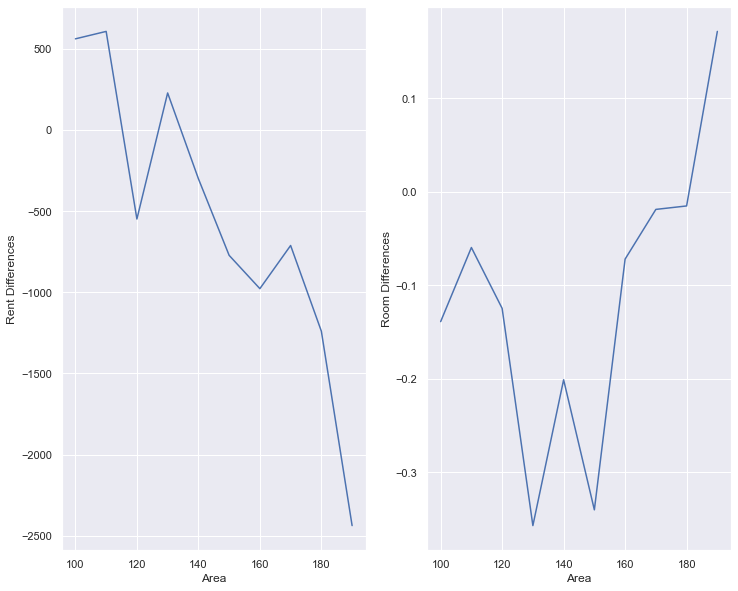

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))
sns.lineplot(x=counters, y=rent_diffs, ax=axs[0]).set(xlabel="Area", ylabel="Rent Differences")
sns.lineplot(x=counters, y=room_diffs, ax=axs[1]).set(xlabel="Area", ylabel="Room Differences")

The 'parking spaces' column does affect the area, even when the amount of rooms and area stays relatively consistent throughout. As such, we should keep this feature in our model. Interestingly, though, at first, the apartments/houses with less parking spaces cost more relative to apartments/houses with more parking spaces. As area increases, this trend changes, however. This is an interesting observation. I think people who go for smaller apartments are looking for less expensive options, and so, it is probable that they do not own as many cars as the people looking for larger apartments. As such, the people, who are in the market for smaller housing, are more likely to pass up on apartments/houses with more parking spaces, driving up the prices of apartments with less parking spaces.

**The 'floor' column:**

The floor column indicates on which floor the apartment is. As mentioned previously, if the observation is on the 0th floor, then that observation is a house. Unlike our previous columns, this column is unlikely to have any connection with other potential features. As such, we only need to check whether this column has a relationship with the target variable.

In [111]:
training_dataset[["floor", "rent amount (R$)"]].corr()

,floor,rent amount (R$)
floor,1.000000,0.102099
rent amount (R$),0.102099,1.000000


The linear correlation with the 'rent amount (R$)' column is incredibly weak. It is possible, though, that the houses are on average more expensive than apartments. As such, let's check whether this is the case with our dataset. 

In [112]:
training_dataset[training_dataset["floor"] == 0][["area", "rent amount (R$)"]].mean()

area                 224.598166
rent amount (R$)    4768.480583
dtype: float64

In [113]:
training_dataset[training_dataset["floor"] > 0][["area", "rent amount (R$)"]].mean()

area                 113.647732
rent amount (R$)    3550.870209
dtype: float64

Based on the above tables, we can see that, on average, houses are more expensive to rent than apartments; however, we must also pay attention to the average area, which is larger for houses. This factor could be influencing the average rent values. So, to get valid results, we shall remove the largest houses from the dataframe with houses until we are within 1% of the average area value for apartments. We will then measure average rent and see if we get similar results.

In [114]:
houses_df = training_dataset[training_dataset["floor"] == 0].sort_values("area", ascending=False)
avg_houses_area = houses_df["area"].mean()
aps_df = training_dataset[training_dataset["floor"] > 0]
avg_aps_area = aps_df["area"].mean()
avg_aps_rent = aps_df["rent amount (R$)"].mean()

one_perc = 1.01 * avg_aps_area
while avg_houses_area > one_perc:
    first_index = houses_df.index[0]
    houses_df.drop(first_index, inplace=True)
    avg_houses_area = houses_df["area"].mean()
avg_houses_rent = houses_df["rent amount (R$)"].mean()
print(f"Difference in area {avg_houses_area - avg_aps_area}")
rent_diff = avg_houses_rent - avg_aps_rent
print(f"Difference in rent {rent_diff}")

Difference in area 1.0344315116153382
Difference in rent -675.6673351432155


As you can see, despite having similar average areas, the difference between houses and apartments is quite large. Let's check whether this value is statistically significant or not by conducting a two-tailed hypothesis test. Since we haven't specifically used the 'floor' column, we will make a custom one which will denote whether the observation is an apartment or a house. 1 is going to denote if an observation is an apartment, and 0 if the observation is a house.

In [115]:
floor_df = pd.concat([houses_df, aps_df])
floor_df["floor_bool"] = floor_df["floor"] > 0
floor_df["floor_bool"] = floor_df["floor_bool"].astype(int)

In [116]:
np.random.seed(10)
n = 1000
sim_stats = []
for i in range(n):
    floor_copy = floor_df.copy()
    shuffled_labels =  pd.DataFrame(floor_copy["floor_bool"].values, index=np.random.permutation(floor_copy.index), columns=["shuffled_floor_bool"])
    floor_copy = floor_copy.merge(shuffled_labels, left_index=True, right_index=True)
    means = floor_copy.groupby("shuffled_floor_bool").mean()["rent amount (R$)"].values.tolist()
    sim_stats.append(means[0] - means[1])

In [117]:
counter = 0
for sim in sim_stats:
    if abs(rent_diff) <= abs(sim):
        counter += 1
counter / n

0.0

As you can see, our p-value is 0, meaning that we have strong evidence that the type of the observation does affect the rent amount. As such, we will keep the feature "floor_bool" in our training dataset and use it when training our model.

We are almost done with this column. Another thing I am curious about is whether the floor value affects the rent amount in apartments **only**. The reason why there could possibly be a positive correlation is because a higher floor could lead towards better views, making the apartment more attractive for potential tenants. Let's check for this using our dataset.

In [118]:
aps_df = training_dataset[training_dataset["floor"] > 0]
aps_df[["floor", "rent amount (R$)"]].corr()

,floor,rent amount (R$)
floor,1.000000,0.251611
rent amount (R$),0.251611,1.000000


<AxesSubplot:xlabel='floor', ylabel='rent amount (R$)'>

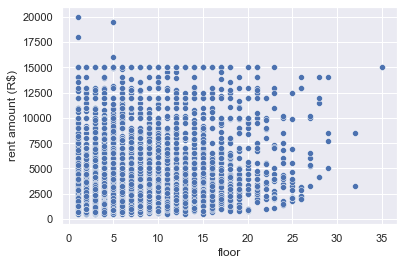

In [119]:
sns.scatterplot(x="floor", y="rent amount (R$)", data=aps_df)

Based on the above scatterplot and table, we can see that the correlation between the 'floor' column and 'rent amount (R$)' is quite weak and is not worth including into our model. As such, we will drop the 'floor' column and only include the new 'floor_bool' feature.

In [120]:
X_train["floor_bool"] = X_train["floor"] > 0
X_train["floor_bool"] = X_train["floor_bool"].astype(int)
X_test["floor_bool"] = X_test["floor"] > 0
X_test["floor_bool"] = X_test["floor_bool"].astype(int)

In [121]:
X_train.drop("floor", axis=1, inplace=True)
X_test.drop("floor", axis=1, inplace=True)

**The 'animal' column**:

The 'animal' column indicates whether the potential tenant can bring an animal into the house/apartment. It is not immediately clear whether this column will have a strong effect on the rent column, because not everyone owns pets or plans to in the future. As such, let's take a close look at the data to determine whether this column needs to be a feature in our model.

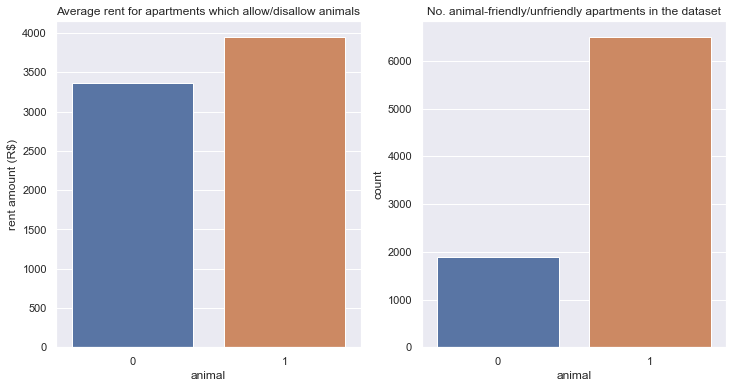

In [122]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
sns.barplot(data=training_dataset[["animal", "rent amount (R$)"]].groupby("animal").mean().reset_index(), y="rent amount (R$)", x="animal", ax=axs[0])
axs[0].set_title("Average rent for apartments which allow/disallow animals")
sns.countplot(data=training_dataset, x="animal", ax=axs[1])
axs[1].set_title("No. animal-friendly/unfriendly apartments in the dataset")
plt.show()

In [123]:
training_dataset[["area", "rooms", "rent amount (R$)", "animal"]].groupby("animal").mean()

,area,rooms,rent amount (R$)
animal,,,
0,107.528451,2.099579,3362.410432
1,147.055342,2.571099,3952.891161


The price difference is confirmed by both the plot and the table above; however, there's also a large difference in the mean 'area' measurements for the two categories, which could be the reason the prices are so different. As such, we will complete a similar investigation as previously and attempt to get similar areas for the two categories and measuring the difference in rent only then.

In [124]:
animal_group = training_dataset[["area", "rooms", "rent amount (R$)", "animal"]].groupby("animal").get_group(1)
animal_group.sort_values("area", ascending=False, inplace=True)
area_mean = animal_group["area"].mean()
while area_mean > 105:
    animal_group = animal_group.iloc[1:]
    area_mean = animal_group["area"].mean()

In [125]:
animal_table = training_dataset[["area", "rooms", "rent amount (R$)", "animal"]].groupby("animal").mean()
no_animal_area = animal_table.loc[0, "area"]
animal_area = animal_group["area"].mean()
print(f"Difference in Area: {no_animal_area - animal_area}")

Difference in Area: 2.541625293380605


In [126]:
no_animal_room = animal_table.loc[0, "rooms"]
animal_room = animal_group["rooms"].mean()
print(f"Difference in Rooms: {no_animal_room - animal_room}")

Difference in Rooms: -0.24865008808687605


In [127]:
no_animal_rent = animal_table.loc[0, "rent amount (R$)"]
animal_rent = animal_group["rent amount (R$)"].mean()
animal_test_statistic = no_animal_rent - animal_rent
print(f"Difference in Rent: {animal_test_statistic}")

Difference in Rent: 133.8875550531252


As you can see, the difference has reduced by quite a bit; however, it is unclear whether this difference is statistically significant or not. To check for statistical signifiance, we will conduct another two-tailed hypothesis test. 

In [128]:
no_animal_group = training_dataset[["area", "rooms", "rent amount (R$)", "animal"]].groupby("animal").get_group(0)
total_animal = pd.concat([animal_group, no_animal_group])

In [129]:
np.random.seed(22)
sim_data = []
repetitions = 1000
for i in range(repetitions):
    animal_copy = total_animal.copy()
    animal_copy["shuffled_labels"] = pd.DataFrame(animal_copy["animal"].values, index=np.random.permutation(animal_copy.index))
    means = animal_copy.groupby("shuffled_labels").mean()["rent amount (R$)"].values.tolist()
    diff = means[0] - means[1]
    sim_data.append(diff)

In [130]:
total = 0
for sim in sim_data:
    if abs(sim) > animal_test_statistic:
        total += 1
total / repetitions 

0.075

The p-value that we obtained from our statistical experiment suggests that we have weak evidence for the hypothesis that our difference is statistically signifiance. In turn, this suggests that the 'animal' column should not be considered as a feature in our model, because it does not affect the target variable strongly.

In [131]:
X_train.drop("animal", axis=1, inplace=True)
X_test.drop("animal", axis=1, inplace=True)

**The 'furniture' column:**

The furniture column indicates whether a partcular apartment is furnished or not. Logically, this column would positively correlate with the target variable, since an unfurnished apartment would require a potential tenant to purchase their own furniture, driving their total cost up. As such, they would not be willing to pay as much for an unfurnished apartment. On the other hand, though, an unfurnished apartment means that the tenant can design it to their liking, which might be more attractive to certain people. So, let's check whether this feature has any influence on the target variable.

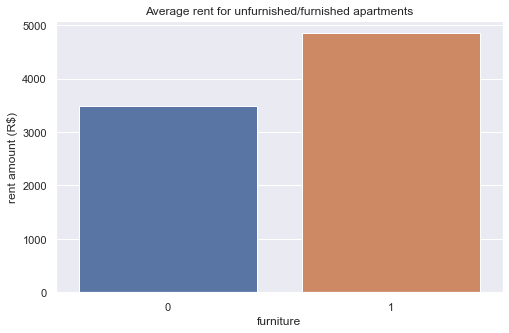

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
sns.barplot(data=training_dataset[["furniture", "rent amount (R$)"]].groupby("furniture").mean().reset_index(), y="rent amount (R$)", x="furniture") 
ax.set_title("Average rent for unfurnished/furnished apartments")
plt.show()

In [133]:
training_dataset[["area", "rooms", "rent amount (R$)", "furniture"]].groupby("furniture").mean()

,area,rooms,rent amount (R$)
furniture,,,
0,138.379332,2.509767,3487.079238
1,137.348905,2.325061,4846.439416


As you can see, there's a significant difference in the average rent amount between unfurnished and furnished apartments, even when the size of the apartments/houses is quite similar. Let's check whether this difference is statistically significant or not by conducting a two-tailed hypothesis test.

In [134]:
furniture_means = training_dataset.groupby("furniture").mean()["rent amount (R$)"].values.tolist()
test_statistic = furniture_means[0] - furniture_means[1]

Let's now simulate test statistics, assuming that furniture does not affect the price of a house/apartment, and compare our test statistic to the estimated sampling distribution.

In [135]:
np.random.seed(33)
sim_data = []
repetitions = 1000
for i in range(repetitions):
    furniture_copy = training_dataset.copy()
    furniture_copy["shuffled_labels"] = pd.DataFrame(furniture_copy["furniture"].values, index=np.random.permutation(furniture_copy.index))
    means = furniture_copy.groupby("shuffled_labels").mean()["rent amount (R$)"].values.tolist()
    diff = means[0] - means[1]
    sim_data.append(diff)

In [136]:
total = 0
for sim in sim_data:
    if sim > abs(test_statistic) or sim < test_statistic:
        total += 1
total / 1000

0.0

After conducting the experiment, we received a p-value of 0, which means that our initial difference is statistically significant. From this, we can conclude that the 'furniture' column affects the target variable and should become a feature in our model.

### Model-Building

Now, we will begin building our model. In order to build this model, we are going to be using the Random Forest Regressor. I think the RFR model is the most appropriate in this case, because the relationships that we saw in our model aren't linear and are quite spread out, and the RFR model will best adapt to this. It is also an ensemble of Random Tree models, which will drive up our accuracy, since it will have a wide range of models making the predictions. Let's begin by training the model.

At first, we are going to use the default parameters of the model; however, we will optimize it later in order to obtain better results.

In [137]:
init_model = RandomForestRegressor(random_state=15)
init_model.fit(X_train, y_train)

RandomForestRegressor(random_state=15)

In [138]:
init_predictions = init_model.predict(X_test)
mean_absolute_error(init_predictions, y_test)

1379.4263137377511

In [139]:
y_train["rent amount (R$)"].mean()

3819.5182672854935

Our initial model with default parameters has a mean absolute error of about 1380 BRL, which is quite a lot, especially considering that the mean of the target variable in our training data is only abour 3820 BRL. Let's try optimizing the model in order to obtain better results.

We will begin optimizing the model by changing the main parameter, the number of estimators. We will increment the number of estimators by 10 starting from 10 estimators and go up to 500 estimators. We will measure the accuracy of the model with different amount of estimators and see the optimal amount of estimators for our model. 

In [140]:
n_estimators = 10
estimators_list = []
accuracy_list = []
while n_estimators <= 500:
    rfr_model = RandomForestRegressor(n_estimators=n_estimators, random_state=15)
    rfr_model.fit(X_train, y_train)
    predictions = rfr_model.predict(X_test)
    accuracy_list.append(mean_absolute_error(predictions, y_test))
    estimators_list.append(n_estimators)
    n_estimators += 10

[Text(0.5, 1.0, 'Accuracy of RFR with Different Amount of Estimators')]

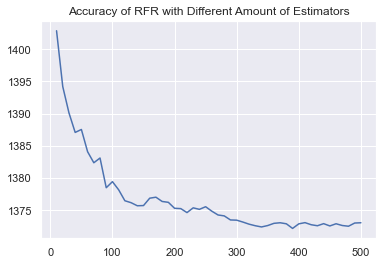

In [141]:
sns.lineplot(x=estimators_list, y=accuracy_list).set(title="Accuracy of RFR with Different Amount of Estimators")

As you can see on the above plot, the inaccuracy of the model decreases as we increase the number of estimators; however, closer to the 400 mark, it dips and we get the most accurate model. Let's find the number of estimators where the inaccuracy is the least in our model.

In [142]:
min_accuracy = accuracy_list[0]
min_index = 0
for index, accuracy in enumerate(accuracy_list):
    if accuracy < min_accuracy:
        min_index = index
        min_accuracy = accuracy
min_accuracy

1372.1614016404744

In [143]:
n_estimators_optimal = estimators_list[min_index]
n_estimators_optimal

390

Now that we determined the optimal amount of estimators, we can also optimize the maximum depth of a tree. We are going to start with maximum depth of 10 and increase it by 10 until we reach 200. Throughout this process, we are going to continue using 400 number of estimators.

In [144]:
max_depth_list = []
accuracy_list = []
max_depth = 10
while max_depth <= 200:
    rfr_model = RandomForestRegressor(n_estimators=n_estimators_optimal, max_depth=max_depth, random_state=15)
    rfr_model.fit(X_train, y_train)
    predictions = rfr_model.predict(X_test)
    accuracy_list.append(mean_absolute_error(predictions, y_test))
    max_depth_list.append(max_depth)
    max_depth += 10

<AxesSubplot:>

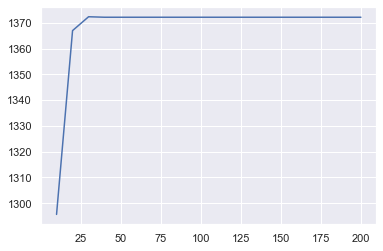

In [145]:
sns.lineplot(x=max_depth_list, y=accuracy_list)

As you can see, we are better off having a relatively low value for maximum depth, because as soon as we increase it beyond around 10 or 15, the inaccuracy of our model greatly increases. Let's find what our maximum depth should be in order to ensure the best results for the model.

In [146]:
min_accuracy = accuracy_list[0]
min_index = 0
for index, accuracy in enumerate(accuracy_list):
    if accuracy < min_accuracy:
        min_index = index
        min_accuracy = accuracy
min_accuracy

1295.679563058977

In [147]:
max_depth_optimal = max_depth_list[min_index]
max_depth_optimal

10

The optmal maximum depth of the trees in our Random Forest model is 10. By having this maximum depth, we have improved our model by a substantial amount, showing the importance of this parameter and optimization in general. Let's now build our final model and get our set of predictions for the test dataset with it.

In [148]:
final_model = RandomForestRegressor(n_estimators=n_estimators_optimal, max_depth=max_depth_optimal, random_state=15)
final_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=390, random_state=15)

In [149]:
final_predictions = final_model.predict(X_test)
mean_absolute_error(final_predictions, y_test)

1295.679563058977

### Looking at Accuracy in More Detail

As we saw previously during our analysis, our data's distribution is quite wide, and our dataset contains houses/apartments which range from low-class to high-class housing. As such, perhaps our model performs differently across these different classes and is better at predicting the rent of particular apartments. Let's check whether this is true by using a clustering algorithm to classify the observations and  the accuracy of our model for each of these clusters individually. 

We are going to be using the KMeans algorithm to cluster our data. We will split the observations into three groups: low-class housing, medium-class housing, and, finally, high-class housing. Let's start by initializing the clustering model and training it on our data.

In [150]:
k_means = KMeans(n_clusters=3, random_state=33)
training_dataset = X_train.merge(y_train, left_index=True, right_index=True)
k_means.fit(training_dataset)

KMeans(n_clusters=3, random_state=33)

We will now analyze the clusters that were created to see if we can gain insight into the data and ensure that the algorithm worked as we planned.

In [151]:
training_dataset["labels"] = pd.DataFrame(k_means.labels_, index=training_dataset.index)

In [152]:
area_table = training_dataset.groupby("labels").mean()["area"]
rent_table = training_dataset.groupby("labels").mean()["rent amount (R$)"]

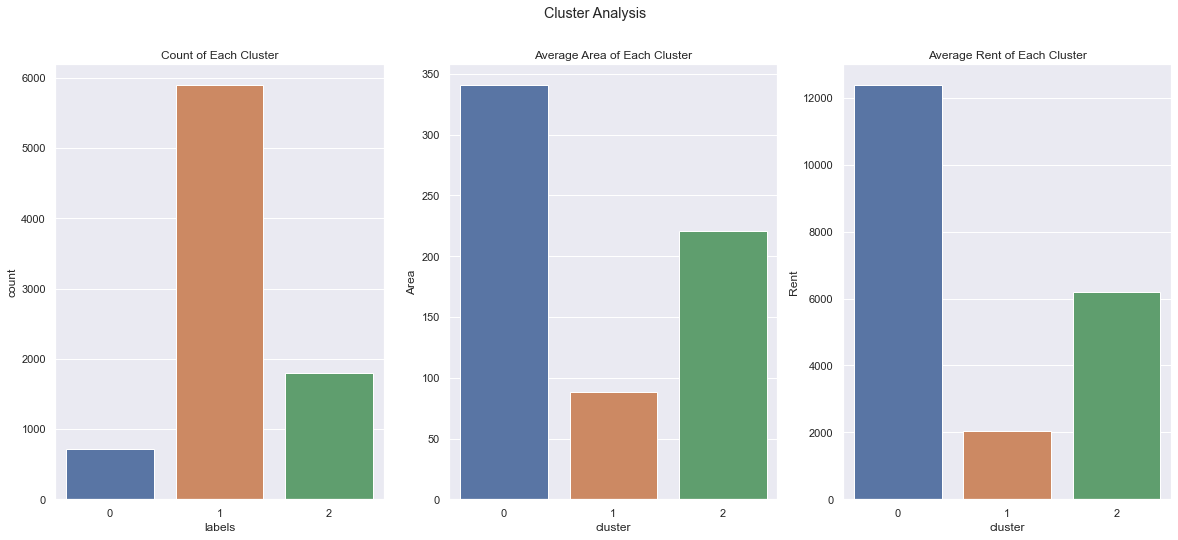

In [153]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
sns.countplot(x="labels", data=training_dataset, ax=axs[0]).set(title="Count of Each Cluster")
sns.barplot(x=area_table.index, y=area_table.values, ax=axs[1]).set(title="Average Area of Each Cluster", xlabel="cluster", ylabel="Area")
sns.barplot(x=rent_table.index, y=rent_table.values, ax=axs[2]).set(title="Average Rent of Each Cluster", xlabel="cluster", ylabel="Rent")
plt.suptitle("Cluster Analysis")
plt.show()

Based on the plots above, we can see that most of the data is located in the 1st cluster, which also contains the smallest and least expensive apartments. This support our earlier distributions, where we saw that a majority of apartments were relatively small and inexpensive. Clearly, the 1 cluster represents the low-class housing on the Brazilian market. The houses/apartments in the 2nd cluster are on average bigger and more expensive than the houses/apartments in the 1st cluster. This cluster represents medium-class housing. Finally, we have the 0th cluster, which contains the largest and most expensive apartments/houses of our dataset; logically, the 2nd cluster contains high-class housing. These clear distinctions between the clusters indicate that the clustering algorithm worked as intended, and we can continue with our analysis.

We will now use the clustering algorithm to classify the testing dataset and use the predictions from earlier in order to measure the accuracy of each cluster individually. 

In [154]:
testing_dataset = X_test.merge(y_test, left_index=True, right_index=True)
test_labels = k_means.predict(testing_dataset)
testing_dataset["labels"] = pd.DataFrame(test_labels, index=testing_dataset.index)
testing_dataset["predictions"] = pd.DataFrame(final_predictions, index=testing_dataset.index)
testing_dataset["inaccuracy"] = abs(testing_dataset["rent amount (R$)"] - testing_dataset["predictions"])

In [155]:
inaccuracy_table = testing_dataset.groupby("labels").mean()["inaccuracy"]

[Text(0.5, 1.0, 'Average Inaccuracy in Each Cluster'),
 Text(0.5, 0, 'Cluster'),
 Text(0, 0.5, 'Inaccuracy')]

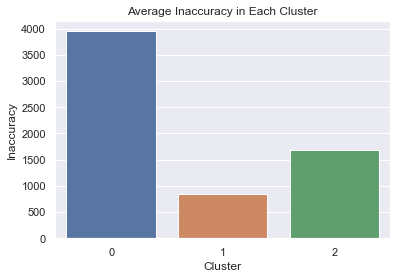

In [156]:
sns.barplot(x=inaccuracy_table.index, y=inaccuracy_table.values).set(title="Average Inaccuracy in Each Cluster", xlabel="Cluster", ylabel="Inaccuracy")

The above barplot shows that the low-class housing cluster is the most accurate out of the three, with the medium-class housing cluster being the second most accurate, and the high-class hosing cluster being the least accurate. So, does that mean our model works best for low-class houses? Well, not exactly. 

If we consider the average rent amount for each of the clusters, then low-class housing cluster no longer seems to be the most accurate. In order to understand how 'truly' accurate each cluster is, we need to consider the average inaccuracy that we just measured in terms of the average rent of each cluster.

In [157]:
inaccuracy_adjusted_table = rent_table.to_frame().merge(inaccuracy_table, left_index=True, right_index=True) 

In [158]:
inaccuracy_adjusted_table["proportion"] = inaccuracy_adjusted_table["inaccuracy"] / inaccuracy_adjusted_table["rent amount (R$)"] * 100
inaccuracy_adjusted_table

,rent amount (R$),inaccuracy,proportion
labels,,,
0,12376.124128,3950.628675,31.921372
1,2053.741306,843.719308,41.082064
2,6205.988833,1682.289339,27.107515


In [159]:
inaccuracy_adjusted_table["proportion"].mean()

33.370316899886326

As you can see, despite our initial belief that the low-class housing cluster was the most accurate, it is actually the least accurate out of the three clusters. On average, our model is off by about 41% for this cluster. Our most accurate cluster is actually the medium-class housing cluster; our model, on average, is off by about 27%, which is a stark improvement compared to the 0th cluster. Finally, for the high-class housing cluster, our model is off by about 32%. Overall, our model is off by about 33%. I am somewhat happy with this result; however, we should always try to improve the model further and I have a couple of ideas and how we can possibly do that.

### How can we improve our model? / Why wasn't our model more accurate?

Although the two questions in the subheading sound similar, I am going to be answering them very differently. When answering the first question of the subheading, I will be focusing on my own method and my own analysis and how I can improve it. On the other hand, when answering the second question of the subheading, I will be focusing on the dataset itself, and the real estate market in general.

Let's begin by answering the first question of our subheading: how can we improve our model? There are a couple of things we could incorporate into our method to improve the performance of our model.

Firstly, as we saw previously, this model contains quite a few outliers, which stem from inconsistencies in the data. For instance, certain large houses/apartments had no parking, which is an unrealistic scenario. We tackled this by using a multivariate outlier detection technique, Mahalanobis Distance; however, we used a large cutoff-value, which we obtained from the Chi-Square distribution and a low significance value of 0.01. Perhaps, if we increased this significance value, to 0.05 for instance, we would identify more outliers, and then possibly remove more extremely unlikely observations, which currently decrease the performance of our model. There would be two downsides to this. Firstly, if we continued to use my method, we would have to go through more observations and check them by hand to see which value was 'strange'. This would take considerably more time, and there's no guarantee that this would substantially improve the performance of our model. Secondly, removing more values from the data isn't always the best solution to improving the model. Those observations could possibly be legitimate and pointing towards a particular trend in our data. This is not something we have to worry about too much when we have a really low significance value, because those identified outliers are incredibly far from the general data and are truly outliers. However, as we increase our significance value, this becomes a larger issue, because we begin removing observations which are not as far from the data and are less likely to be "extreme" observations. Additionally, in regards to outliers, we could also have used another method to identify outliers, in addition to Mahalanobis Distance, such as the Density-Based Spatial Clustering algorithm (DBSCAN), which is capable of identifying outliers; however, as we saw in [my previous notebook](https://www.kaggle.com/karimzakir02/outlier-detection-techniques), DBSCAN requires a lot of setup to work well.

Secondly, when selecting features, we could have checked the effect of our potential features on the target variable by using more advanced statistical methods, such as ANOVA, or we could have used sklearn's inbuilt function for feature selection. The reason why I have not used these methods in this notebook is because I wanted to stick to more simple and traditional methods, like correlation. However, later, I will make sure to use these methods with this dataset or another one, because not only will I see if they improve the model, but also to learn them and understand better how to work with them. 

I am sure that my method in this notebook could be improved in infinitely more ways. So, if you have any more suggestions, I would really appreciate you commenting them below!

Now, let's move on to the second question: why wasn't our model more accurate? As mentioned previously, now I will be talking more about the dataset itself. 

I think this dataset lacks some features that could have been useful in our analysis. Don't get me wrong, this dataset contains a good amount of features that are quite useful for our model, but there is definitely more data that could be scraped about the real estate in Brazil. For instance, does the building where the apartment is have a gym or a pool or any other extra benefits that could interest the tenants? Or how close is the nearest public transport point to the apartment? All of these potential features, which are hard to obtain, could have greatly improved our model and analysis in general.

Additionally, I had the opportunity to talk to a data scientist who closely works with real estate data, but mostly focuses on predicting prices of real estate offered for sale, not rent. He said that in his personal experience, he found that predicting the rent price is much harder than predicting the sale price, because a huge factor that comes into play for tenants is the "coziness" factor. This factor is extremely difficult to quantify, perhaps even impossible, and it's also incredibly subjective to each tenant, so this shows that there are certain features that we can't even create or use in our model, because they are so hard to obtain.

Again, the dataset could be improved in infinitely many ways, like almost anything in the world, so if you have any ideas/suggestions on what else could be added to the dataset, comment them down below. I would love to hear your insight!

### Conclusion

In conclusion, the model that we have developed is off by about 33% on average. This isn't too bad, but it's obviously not perfect either. Above, I have spoken about how this model can be improved and it's definitely something I will explore later in the future. If you have any ideas/suggestions, make sure to comment them in the [Kaggle Version](https://www.kaggle.com/karimzakir02/brazilian-houses-model) of this notebook or by even opening an issue on Github!

Thank you for taking your time to read this notebook! I hope you enjoyed it or even learnt from it!